In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numba as nb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, logPr

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from true_distribution import generate_Xsamples

### Derivation of mean/covariance of X

$\newcommand{\E}{\mathrm{E}}$ -->
$\newcommand{\Var}{\mathrm{Var}}$
$\newcommand{\Cov}{\mathrm{Cov}}$ -->
$$
\E(X_i) = \E\left(\prod_{k=1}^{i} t_k \right) = \prod_{k=1}^{i} \E(t_k) = \prod_{k=1}^{i} \frac{n_k}{n_k + 1}
$$
To find the covariance, consider
$$
\Cov(A, AB) = \E(A^2 B) - \E(A)\E(AB) = \left[\E(A^2) - \E(A)^2\right]\E(B)
$$
if $A, B$ are independent. Assume $i<j$ w.l.o.g; 
$$
\Cov(X_i, X_j) = \Cov(t_1 \cdots t_i, t_1 \cdots t_j) = \mathrm{Var}(t_1 \cdots t_i) \E(t_{i+1} \cdots t_j)
$$
$$
\Cov(X_i, X_j) = \left[\prod_{k=1}^{i} \frac{n_k}{n_k + 2} - \left(\prod_{k=1}^{i} \frac{n_k}{n_k + 1}\right)^2\right] \left(\prod_{k=i+1}^{j} \frac{n_k}{n_k + 1} \right)
$$

More generally, 
$$
\Cov(X_i, X_j) = \left[\prod_{k=1}^{\min(i,j)} \frac{n_k}{n_k + 2} - \left(\prod_{k=1}^{\min(i,j)} \frac{n_k}{n_k + 1}\right)^2\right] \left(\prod_{k=\min(i,j)+1}^{\max(i,j)} \frac{n_k}{n_k + 1} \right)
$$

In [2]:
def mean_X(nk):
    return np.cumprod(nk/(nk+1))

def cov_X(nk):
    t_1 = np.cumprod(nk/(nk+1)) # cumulative product of expectation of t
    t_2 = np.cumprod(nk/(nk+2)) # cumulative product of expectation of t^2
    iterations = len(nk)
    cov_X = np.zeros((iterations, iterations))
    for i in range(iterations):
        cov_X[i][i] = t_2[i] - t_1[i]**2 
        for j in range(i+1, iterations): # start j above i so min(i,j) automatically fulfilled
            correlated = t_2[i] - t_1[i]**2
            independent = t_1[j]/t_1[i] # cumulative product from i+1 to j
            cov_X[i][j] = cov_X[j][i] = correlated * independent
    return cov_X

### Comparison of analytic vs numerical means/covariances

In [9]:
nk = 500 * np.ones(100)
Xsamples = generate_Xsamples(nk, 100000)

2.8839644517044904e-05


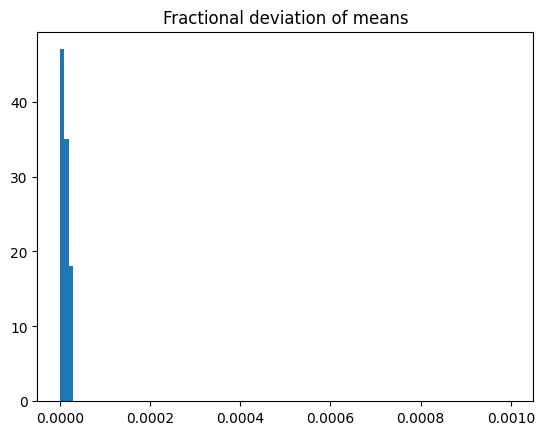

In [10]:
mean_a = mean_X(nk)
mean_rand = np.mean(Xsamples, axis=0)
frac_devs_mean = abs((mean_a - mean_rand)/mean_a).flatten()
plt.hist(frac_devs_mean, range=[0,1e-3], bins=100);
print(frac_devs_mean.max())
plt.title("Fractional deviation of means");

0.04497661122384336


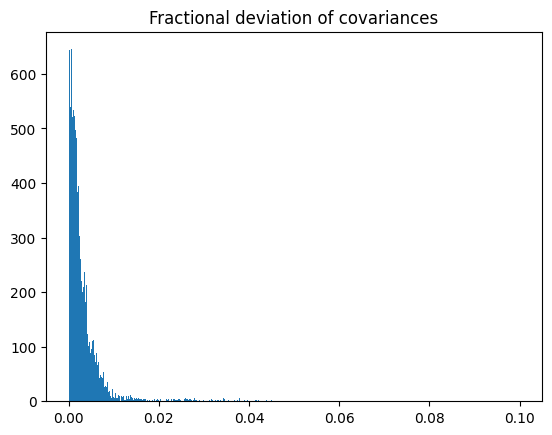

In [11]:
cov_a = cov_X(nk)
cov_rand = np.cov(Xsamples.T)
frac_devs_cov = abs((cov_a - cov_rand)/cov_a).flatten()
plt.hist(frac_devs_cov, range=[0,0.1], bins=500);
print(frac_devs_cov.max())
plt.title("Fractional deviation of covariances");

### Do the same for logX

In [12]:
logXsamples = np.log(Xsamples)

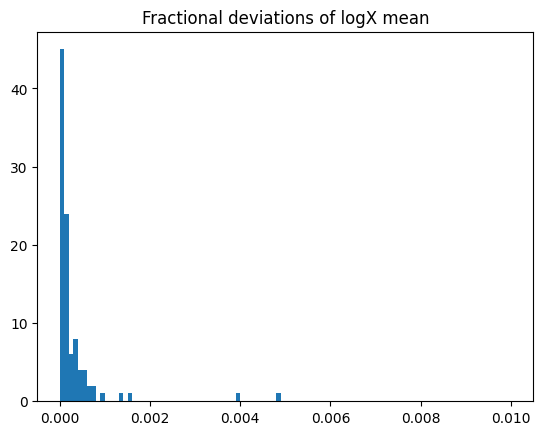

In [13]:
logXmean_a = logX_mu(nk)
logXmean_rand = np.mean(logXsamples, axis=0)
frac_dev_logXmean = abs((logXmean_a - logXmean_rand)/logXmean_a)
plt.hist(frac_dev_logXmean, bins=100, range=[0,0.01]);
plt.title("Fractional deviations of logX mean");

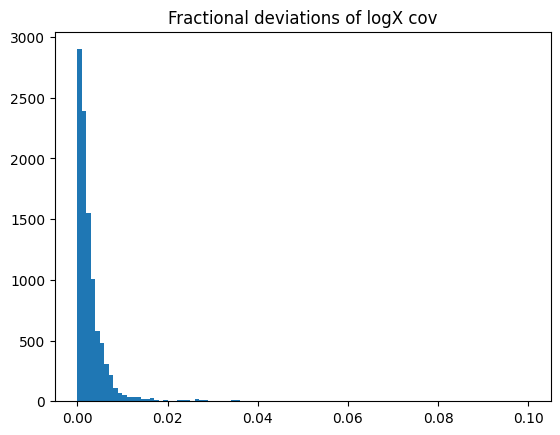

In [14]:
logXcov_a = np.linalg.inv(logX_covinv_chol(nk))
logXcov_rand = np.cov(logXsamples.T)
frac_dev_logXcov = abs((logXcov_a - logXcov_rand)/logXcov_a).flatten()
plt.hist(frac_dev_logXcov, bins=100, range=[0,0.1]);
plt.title("Fractional deviations of logX cov");